#第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

##50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が"Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"の事例（記事）のみを抽出する．
抽出された事例をランダムに並び替える．
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [ ]:
!curl 'https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip' >news.zip
!unzip news.zip
!head -10 readme.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.8M  100 27.8M    0     0  19.2M      0  0:00:01  0:00:01 --:--:-- 19.2M
Archive:  news.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2pageSessions.csv       
replace __MACOSX/._2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: SUMMARY: Dataset of references (urls) to news web pages

DESCRIPTION: Dataset of references to news web pages collected from an online aggregator in the period from March 10 to August 10 of 2014. The resources are grouped into clusters that represent pages discussing the same news story. The dataset includes also references to web pages that point (has a link to) one of the news page in the collection.

TAGS: web pages, news, aggregator, classification, clustering

LICENSE: Public domain - Due to restrictions on content and use of the news sources, the corp

In [ ]:
!head -10 2pageSessions.csv
!head -10 newsCorpora.csv

dxyGGb4iN9Cs9aMZTKQpJeoiQfruM	techcrunch.com	b	http://techcrunch.com/ http://techcrunch.com/2014/03/10/ebay-asks-shareholders-to-vote-against-paypal-split-while-icahn-claims-ceo-incompetence-cost-4b/ 
dxyGGb4iN9Cs9aMZTKQpJeoiQfruM	techcrunch.com	b	http://techcrunch.com/ecommerce/ http://techcrunch.com/2014/03/10/ebay-asks-shareholders-to-vote-against-paypal-split-while-icahn-claims-ceo-incompetence-cost-4b/ 
dxyGGb4iN9Cs9aMZTKQpJeoiQfruM	www.bnn.ca	b	http://www.bnn.ca/News/2014/ http://www.bnn.ca/News/2014/3/10/EBay-asks-shareholders-to-vote-against-Icahn-board-nominees.aspx 
dxyGGb4iN9Cs9aMZTKQpJeoiQfruM	www.bnn.ca	b	http://www.bnn.ca/news http://www.bnn.ca/News/2014/3/10/EBay-asks-shareholders-to-vote-against-Icahn-board-nominees.aspx 
dxyGGb4iN9Cs9aMZTKQpJeoiQfruM	www.bnn.ca	b	http://www.bnn.ca/News/News-Listing.aspx?Sector=Investing http://www.bnn.ca/News/2014/3/10/EBay-asks-shareholders-to-vote-against-Icahn-board-nominees.aspx 
dxyGGb4iN9Cs9aMZTKQpJeoiQfruM	www.bnn.ca	b	http://ww

In [ ]:
import random
import pandas as pd
from sklearn.model_selection import train_test_split

#データの読み込み
file = 'newsCorpora.csv'

t_list = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
n_list = []
with open(file, mode='r', encoding='utf-8') as f:
  #1行ずつ読み込み
  for line in f:
    n_line = line.split('\t')
    if n_line[3] in t_list:
      n_list.append(n_line)

#ランダムに並べ替え
random.shuffle(n_list)

#dataframeに変換
df = pd.DataFrame(n_list, columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
print(df['PUBLISHER'].head(10))

#学習、検証、評価に分割
train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=1)
valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=1)

#lengthの確認
print(len(train))
print(len(valid))
print(len(test))

#保存
train[['TITLE', 'CATEGORY']].to_csv('train.txt', sep='\t')
valid[['TITLE', 'CATEGORY']].to_csv('valid.txt', sep='\t')
test[['TITLE', 'CATEGORY']].to_csv('test.txt', sep='\t')

0          Daily Mail
1             Reuters
2    Contactmusic.com
3        Businessweek
4          Daily Mail
5          Daily Mail
6        Businessweek
7     Huffington Post
8             Reuters
9    Contactmusic.com
Name: PUBLISHER, dtype: object
10684
1336
1336


##51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def feature_a(data, clm_name, target):
  #読込
  df = pd.read_csv(data + '.txt', sep='\t', index_col=0)
  df = df.reset_index(drop = True)

  #文字数
  df[clm_name] = df[clm_name].str.lower()
  df['len_c'] = df[clm_name].str.len()

  alpha = 'abcdefghijklmnopqrstuvwxyz'
  for i in alpha:
    df['n_' + i] = df[clm_name].str.count(i)

  #単語数
  df['len_w'] = (df[clm_name].str.split()).str.len()
  return df

df_train = feature_a('train', 'TITLE', 'CATEGORY')
df_valid = feature_a('valid', 'TITLE', 'CATEGORY')
df_test = feature_a('test', 'TITLE', 'CATEGORY')
print(df_train.head(10))

                                               TITLE CATEGORY  ...  n_z  len_w
0  update 3-fiat chrysler shares tumble on strate...        b  ...    0      9
1        guinea's ebola crisis: an interactive guide        m  ...    0      6
2  bny mellon shareholders welcome activist peltz...        b  ...    1      8
3  grains-corn firms for first time in six sessio...        b  ...    0     12
4  remembering the fallen: imperial war museum re...        e  ...    0     10
5  'game of thrones' director calls that controve...        e  ...    0     10
6  gm's latest recall has echoes of earlier ignit...        b  ...    0      9
7  update 2-virgin america files for ipo as us ai...        b  ...    0     10
8  ryan gosling's 'lost river' fails to impress c...        e  ...    0     11
9  update 1-'transformers' turns into box office ...        e  ...    0     11

[10 rows x 30 columns]


In [ ]:
#単語ベクトル(bigramのみ)
vectorizer = CountVectorizer(ngram_range=(2, 2), max_df=0.5, min_df=5)
count = vectorizer.fit_transform(df_train['TITLE'])

#dataframe化
df_cnt = pd.DataFrame(count.toarray(), columns=vectorizer.get_feature_names(), dtype='int8')

#TFIDF
vec_tfidf = TfidfVectorizer(min_df=5)
tfidf = vec_tfidf.fit_transform(df_train['TITLE'])
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=vec_tfidf.get_feature_names())

df_train = pd.merge(df_train, df_cnt, left_index = True, right_index = True, how = 'left')
df_train = pd.merge(df_train, df_tfidf, left_index = True, right_index = True, how = 'left')

df_train = df_train.drop(columns=['TITLE', 'CATEGORY'], axis = 1)

df_train.to_csv('train.feature.txt', sep='\t')
print(df_train.head())

   len_c  n_a  n_b  n_c  n_d  ...  zealand  zendaya  zeppelin  zone  zuckerberg
0     61    5    2    2    2  ...      0.0      0.0       0.0   0.0         0.0
1     43    4    1    2    1  ...      0.0      0.0       0.0   0.0         0.0
2     56    4    1    2    1  ...      0.0      0.0       0.0   0.0         0.0
3     73    4    0    2    0  ...      0.0      0.0       0.0   0.0         0.0
4     74    4    1    0    0  ...      0.0      0.0       0.0   0.0         0.0

[5 rows x 5728 columns]


In [ ]:
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,216403,Call for HIV pill for gay men at risk of infec...,http://www.dailymail.co.uk/news/article-263121...,Daily Mail,m,d3M-mFDyIPzR55MnZIITbXy9CXUiM,www.dailymail.co.uk,1400402015000\n
1,405079,"Sanofi, Regeneron cholesterol drug may cut hea...",http://www.reuters.com/article/2014/07/30/us-s...,Reuters,m,dH_zrU9g2cXtdYMqjtIj_DOPSMv2M,www.reuters.com,1406807496466\n
2,361423,Kanye West Greeted With Boos At London's Wirel...,http://www.contactmusic.com/article/kanye-west...,Contactmusic.com,e,dGPONWp4r1_fc9MhRYgny9hdnX8HM,www.contactmusic.com,1404595904851\n
3,160038,Google Plus Head Gundotra Exits After 8 Years ...,http://www.businessweek.com/news/2014-04-24/go...,Businessweek,t,dDJkjPmSLl4bcKMd2p1G_d4jqB7KM,www.businessweek.com,1398398968422\n
4,135323,Lindsay Lohan's 2 Broke Girls cameo brings in ...,http://www.dailymail.co.uk/tvshowbiz/article-2...,Daily Mail,e,d5VlrjlHOlDZLrMk7arYBB7aG5AQM,www.dailymail.co.uk,1397838792066\n


In [ ]:
df_cnt.head()

,10 billion,10 things,10 year,100 mln,13 percent,14 pct,1st qtr,20 years,2014 growth,2014 mtv,22 jump,2nd day,2nd quarter,30 year,45 billion,50 pct,aa outlook,about her,about his,about how,about the,about to,ac dc,according to,accused of,acm awards,adam levine,adds to,advance as,after being,after china,after ecb,after fed,after gdp,after he,after his,after record,after six,after strong,after the,...,woodley shailene,woody allen,world equities,world health,world news,wrapup china,wrapup us,wren scott,year high,year low,year notes,year old,years after,years ago,years in,years of,yellen comments,yellen says,yellen testimony,yen gains,yen on,yields fall,yields rise,york ap,york city,york times,you are,you can,you ll,you need,you see,you should,you to,young to,your dragon,your mother,yr high,zac efron,zone bonds,zone inflation
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def feature_value(df, name):
  #単語ベクトル
  count = vectorizer.transform(df['TITLE'])

  #dataframe化
  df_cnt = pd.DataFrame(count.toarray(), columns=vectorizer.get_feature_names(), dtype='int8')

  #TFIDF
  tfidf = vec_tfidf.transform(df['TITLE'])
  df_tfidf = pd.DataFrame(tfidf.toarray(), columns=vec_tfidf.get_feature_names())
  df = df.drop(columns = ['TITLE', 'CATEGORY'], axis = 1)
  
  #merge
  df = pd.merge(df, df_cnt, left_index = True, right_index = True, how = 'left')
  df = pd.merge(df, df_tfidf, left_index = True, right_index = True, how = 'left')

  #出力
  df.to_csv(name + '.feature.txt', sep='\t')
  return df

df_valid = feature_value(df_valid, 'valid')
df_test = feature_value(df_test, 'test')
print(df_test.head(10))

   len_c  n_a  n_b  n_c  n_d  ...  zealand  zendaya  zeppelin  zone  zuckerberg
0     44    4    0    6    1  ...      0.0      0.0       0.0   0.0         0.0
1     61    3    0    1    3  ...      0.0      0.0       0.0   0.0         0.0
2     54    4    1    0    0  ...      0.0      0.0       0.0   0.0         0.0
3     85    4    1    3    0  ...      0.0      0.0       0.0   0.0         0.0
4     61    4    1    3    1  ...      0.0      0.0       0.0   0.0         0.0
5     59    5    3    1    0  ...      0.0      0.0       0.0   0.0         0.0
6     67    4    0    4    2  ...      0.0      0.0       0.0   0.0         0.0
7     58    2    1    0    0  ...      0.0      0.0       0.0   0.0         0.0
8     44    2    0    2    1  ...      0.0      0.0       0.0   0.0         0.0
9     65    3    1    2    2  ...      0.0      0.0       0.0   0.0         0.0

[10 rows x 5728 columns]


##52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [ ]:
from sklearn.linear_model import LogisticRegression

df_train = pd.read_csv('train.txt', sep='\t', index_col=0)
feat_train = pd.read_csv('train.feature.txt', sep='\t', index_col=0)

#欠損補完
feat_train = feat_train.fillna(0)

lr = LogisticRegression(penalty = 'l2', max_iter = 500)
lr.fit(feat_train, df_train['CATEGORY'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [ ]:
import numpy as np
def predict(lr, x):
    prob = np.max(lr.predict_proba(x), axis=1)
    pred = lr.predict(x)
    return prob, pred
prob, pred = predict(lr, feat_train)
print(prob[:10], pred[:10])

[0.98531399 0.34018304 0.40527014 0.97690964 0.71496248 0.99612085
 0.61714192 0.95925949 0.96966963 0.94443839] ['b' 'b' 'b' 'b' 'e' 'e' 't' 'b' 'e' 'e']


##54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [ ]:
from sklearn.metrics import accuracy_score

def accurate(df_type, model):
  df1 = pd.read_csv(df_type + '.txt', sep='\t', index_col=0)
  feat1 = pd.read_csv(df_type + '.feature.txt', sep='\t', index_col=0)
  feat1 = feat1.fillna(0)
  prob1, pred1 = predict(model, feat1)
  acc = accuracy_score(df1['CATEGORY'], pred1)
  return acc

train_ac = accurate('train', lr)
test_ac = accurate('test', lr)

print(train_ac)
print(test_ac)

0.8693373268438787
0.8323353293413174


##55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [ ]:
from sklearn.metrics import confusion_matrix

def confusion(df_type, model):
  df1 = pd.read_csv(df_type + '.txt', sep='\t', index_col=0)
  feat1 = pd.read_csv(df_type + '.feature.txt', sep='\t', index_col=0)
  feat1 = feat1.fillna(0)
  prob1, pred1 = predict(model, feat1)
  #混同行列
  cfm = confusion_matrix(df1['CATEGORY'], pred1)
  return cfm

train_cfm = confusion('train', lr)
test_cfm = confusion('test', lr)

print(train_cfm)
print(test_cfm)

[[4252  174   20   67]
 [ 150 4006    9   38]
 [ 208  164  336   27]
 [ 339  179   21  694]]
[[539  29   4  14]
 [ 34 477   0   6]
 [ 16  24  33   8]
 [ 53  35   1  63]]


##56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def score_mean(df_type): 
  df1 = pd.read_csv(df_type + '.txt', sep='\t', index_col=0)
  feat1 = pd.read_csv(df_type + '.feature.txt', sep='\t', index_col=0)
  feat1 = feat1.fillna(0)
  prob1, pred1 = predict(lr, feat1)

  # 適合率
  precision = precision_score(df1['CATEGORY'], pred1, average=None, labels=['b', 'e', 't', 'm'])
  precision = np.append(precision, precision_score(df1['CATEGORY'], pred1, average='micro'))
  precision = np.append(precision, precision_score(df1['CATEGORY'], pred1, average='macro'))

  # 再現率
  recall = recall_score(df1['CATEGORY'], pred1, average=None, labels=['b', 'e', 't', 'm'])
  recall = np.append(recall, recall_score(df1['CATEGORY'], pred1, average='micro'))
  recall = np.append(recall, recall_score(df1['CATEGORY'], pred1, average='macro'))

  # F1スコア
  f1 = f1_score(df1['CATEGORY'], pred1, average=None, labels=['b', 'e', 't', 'm'])
  f1 = np.append(f1, f1_score(df1['CATEGORY'], pred1, average='micro'))
  f1 = np.append(f1, f1_score(df1['CATEGORY'], pred1, average='macro'))

  score = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1}, index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])
  return score

print(score_mean('test'))

             適合率       再現率     F1スコア
b       0.839564  0.919795  0.877850
e       0.844248  0.922631  0.881701
t       0.692308  0.414474  0.518519
m       0.868421  0.407407  0.554622
マイクロ平均  0.832335  0.832335  0.832335
マクロ平均   0.811135  0.666077  0.708173


##57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [ ]:
train = pd.read_csv('train.feature.txt', sep='\t', index_col=0)
feature_names = train.columns.values
#print(feature_names[0])

for c, coef in zip(lr.classes_, lr.coef_): 
    idx = np.argsort(coef)[::-1]
    print(c)
    print(feature_names[idx][:10])
    print(feature_names[idx][-10:][::-1])

b
['us stocks' 'china' 'update' 'to buy' 'as' 'euro' 'global markets'
 'forex dollar' 'stocks' 'ecb']
['miley cyrus' 'kim kardashian' 'the' 'and' 'justin bieber' 'box office'
 'apple' 'facebook' 'as she' 'kanye west']
e
['miley cyrus' 'kim kardashian' 'justin bieber' 'box office' 'of thrones'
 'game of' 'selena gomez' 'lindsay lohan' 'paul walker' 'kanye west']
['update' 'us' 'china' 'says' 'to buy' 'us stocks' 'to' 'may' 'on'
 'global markets']
m
['ebola' 'study' 'cancer' 'ebola outbreak' 'drug' 'fda' 'mers' 'could'
 'health' 'outbreak']
['n_q' 'miley cyrus' 'us stocks' 'ahead of' 'kim kardashian' 'china' 'at'
 'of the' 'deal' 'ceo']
t
['google' 'apple' 'facebook' 'net neutrality' 'microsoft' 'climate change'
 'climate' 'gm' 'mobile' 'google glass']
['us stocks' 'miley cyrus' 'wall st' 'stocks' 'as' 'ecb' 'selena gomez'
 'of thrones' 'box office' 'game of']


##58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

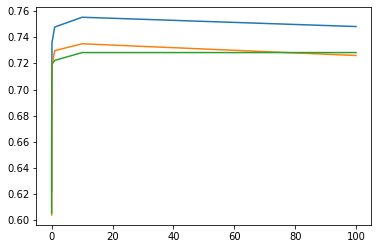

In [ ]:
import matplotlib.pyplot as plt

df_train = pd.read_csv('train.txt', sep='\t', index_col=0)
feat_train = pd.read_csv('train.feature.txt', sep='\t', index_col=0)

#欠損補完
feat_train = feat_train.fillna(0)

#正則化範囲
reg = [10**i for i in range(-3,3)]
lrs = [LogisticRegression(C = C, penalty = 'l2', max_iter = 200).fit(feat_train, df_train['CATEGORY']) for C in reg]

#スコア付
train_acs = [accurate('train', lr1) for lr1 in lrs]
valid_acs = [accurate('valid', lr1) for lr1 in lrs]
test_acs = [accurate('test', lr1) for lr1 in lrs]

plt.plot(reg, train_acs, label = 'train')
plt.plot(reg, valid_acs, label = 'valid')
plt.plot(reg, test_acs, label = 'test')
plt.show()

##59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [ ]:
!pip install optuna

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import optuna

#読込
df_train = pd.read_csv('train.txt', sep='\t', index_col=0)
feat_train = pd.read_csv('train.feature.txt', sep='\t', index_col=0)
df_valid = pd.read_csv('valid.txt', sep='\t', index_col=0)
feat_valid = pd.read_csv('valid.feature.txt', sep='\t', index_col=0)
df_test = pd.read_csv('test.txt', sep='\t', index_col=0)
feat_test = pd.read_csv('test.feature.txt', sep='\t', index_col=0)

#カテゴリ変換
category_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
y_train = df_train['CATEGORY'].map(lambda x: category_dict[x])
y_valid = df_valid['CATEGORY'].map(lambda x: category_dict[x])
y_test = df_test['CATEGORY'].map(lambda x: category_dict[x])

#欠損補完
feat_train = feat_train.fillna(0)
feat_valid = feat_valid.fillna(0)
feat_test = feat_test.fillna(0)

#XGB用データ
feature_names = list(feat_train.columns)
dtrain = xgb.DMatrix(feat_train, label=y_train, feature_names = feature_names )
dvalid = xgb.DMatrix(feat_valid, label=y_valid, feature_names = feature_names )
dtest = xgb.DMatrix(feat_test, label=y_test, feature_names = feature_names )

# 学習データ、検証用データ
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

def objective(trial):
    param = {
        'silent': 1,
        'num_class': 4,
        'objective':  'multi:softmax',
        'eval_metric': 'mlogloss',
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'min_child_weight' : trial.suggest_int('min_child_weight',1,5),
        'subsample' : trial.suggest_uniform('subsample',0.5,1),
        'colsample_bytree' : trial.suggest_uniform('colsample_bytree',0.5,1),
        'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0.5,1),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1e-4)
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 3, 9)
        param['eta'] = trial.suggest_loguniform('eta', 1e-3, 1.0)
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1e-4)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])

    num_round = 200
    early_stopping_rounds = 50
    model = xgb.train(param, dtrain, num_round, evals = watchlist, early_stopping_rounds = early_stopping_rounds)
   
    valid_p = model.predict(dvalid, ntree_limit = model.best_ntree_limit)
    acc = accuracy_score(y_valid, valid_p)
    return acc

#繰り返し数
n= 5
nround = 1000
eround = 50

#チューニング
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n)
print(study.best_trial)

#ベストパラメータで設定
# パラメータの設定
params={'silent': 1,
        'num_class': 4,
        'objective':  'multi:softmax',
        'eval_metric': 'mlogloss'
        }
params = dict(params)
#optunaのパラメータで上書き
params.update(study.best_trial.params)
num_round = nround
early_stopping_rounds = eround
model = xgb.train(params, dtrain, num_round, evals=watchlist,early_stopping_rounds=early_stopping_rounds)

#スコア付
train_p = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
valid_p = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
test_p = model.predict(dtest, ntree_limit=model.best_ntree_limit)

#正解率
train_acc = accuracy_score(y_train, train_p) 
valid_acc = accuracy_score(y_valid, valid_p) 
test_acc = accuracy_score(y_test, test_p) 

print(train_acc)
print(valid_acc)
print(test_acc)

[I 2021-03-02 15:30:07,745] A new study created in memory with name: no-name-4ffa4898-44de-479c-a7bb-ea4e26782e11


[0]	train-mlogloss:1.37532	eval-mlogloss:1.37544
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 50 rounds.
[1]	train-mlogloss:1.36421	eval-mlogloss:1.36492
[2]	train-mlogloss:1.35332	eval-mlogloss:1.35467
[3]	train-mlogloss:1.34253	eval-mlogloss:1.34438
[4]	train-mlogloss:1.33199	eval-mlogloss:1.33434
[5]	train-mlogloss:1.32203	eval-mlogloss:1.3248
[6]	train-mlogloss:1.31229	eval-mlogloss:1.31555
[7]	train-mlogloss:1.30242	eval-mlogloss:1.30631
[8]	train-mlogloss:1.29303	eval-mlogloss:1.29747
[9]	train-mlogloss:1.28384	eval-mlogloss:1.28887
[10]	train-mlogloss:1.27481	eval-mlogloss:1.28052
[11]	train-mlogloss:1.26556	eval-mlogloss:1.2718
[12]	train-mlogloss:1.25682	eval-mlogloss:1.26349
[13]	train-mlogloss:1.24819	eval-mlogloss:1.25521
[14]	train-mlogloss:1.23976	eval-mlogloss:1.24721
[15]	train-mlogloss:1.23157	eval-mlogloss:1.23942
[16]	train-mlogloss:1.22346	eval-mlogloss:1.23169
[17]	train-

[I 2021-03-02 16:02:34,695] Trial 0 finished with value: 0.7739520958083832 and parameters: {'booster': 'gbtree', 'min_child_weight': 5, 'subsample': 0.5485381752297884, 'colsample_bytree': 0.8825223981099259, 'colsample_bylevel': 0.8939525604331864, 'lambda': 0.0013067296192943857, 'alpha': 1.547262615089457e-08, 'max_depth': 8, 'eta': 0.0144951754187416, 'gamma': 6.293074857932698e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.7739520958083832.


[0]	train-mlogloss:1.01033	eval-mlogloss:1.00778
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 50 rounds.
[1]	train-mlogloss:0.882743	eval-mlogloss:0.873856
[2]	train-mlogloss:0.823223	eval-mlogloss:0.820837
[3]	train-mlogloss:0.78103	eval-mlogloss:0.784902
[4]	train-mlogloss:0.75043	eval-mlogloss:0.745823
[5]	train-mlogloss:0.722713	eval-mlogloss:0.727357
[6]	train-mlogloss:0.695704	eval-mlogloss:0.704353
[7]	train-mlogloss:0.674904	eval-mlogloss:0.688721
[8]	train-mlogloss:0.654987	eval-mlogloss:0.672536
[9]	train-mlogloss:0.639107	eval-mlogloss:0.661516
[10]	train-mlogloss:0.626457	eval-mlogloss:0.650039
[11]	train-mlogloss:0.613667	eval-mlogloss:0.639993
[12]	train-mlogloss:0.601087	eval-mlogloss:0.627854
[13]	train-mlogloss:0.586285	eval-mlogloss:0.620505
[14]	train-mlogloss:0.576441	eval-mlogloss:0.60953
[15]	train-mlogloss:0.566452	eval-mlogloss:0.601463
[16]	train-mlogloss:0.555658	eva

[I 2021-03-02 16:14:26,514] Trial 1 finished with value: 0.8375748502994012 and parameters: {'booster': 'gbtree', 'min_child_weight': 5, 'subsample': 0.5398502617559077, 'colsample_bytree': 0.8894373017239856, 'colsample_bylevel': 0.9701107663362214, 'lambda': 0.002414684774706016, 'alpha': 3.152585345051446e-08, 'max_depth': 4, 'eta': 0.8395896365401193, 'gamma': 1.4557825549001653e-08, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.8375748502994012.


[0]	train-mlogloss:1.33292	eval-mlogloss:1.33486
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 50 rounds.
[1]	train-mlogloss:1.28324	eval-mlogloss:1.28856
[2]	train-mlogloss:1.23864	eval-mlogloss:1.24708
[3]	train-mlogloss:1.19834	eval-mlogloss:1.2093
[4]	train-mlogloss:1.16218	eval-mlogloss:1.1752
[5]	train-mlogloss:1.12863	eval-mlogloss:1.1438
[6]	train-mlogloss:1.09719	eval-mlogloss:1.115
[7]	train-mlogloss:1.06812	eval-mlogloss:1.08819
[8]	train-mlogloss:1.0416	eval-mlogloss:1.06308
[9]	train-mlogloss:1.01694	eval-mlogloss:1.0397
[10]	train-mlogloss:0.994219	eval-mlogloss:1.01832
[11]	train-mlogloss:0.97204	eval-mlogloss:0.997809
[12]	train-mlogloss:0.952163	eval-mlogloss:0.979081
[13]	train-mlogloss:0.933812	eval-mlogloss:0.961966
[14]	train-mlogloss:0.915586	eval-mlogloss:0.945048
[15]	train-mlogloss:0.898675	eval-mlogloss:0.9297
[16]	train-mlogloss:0.882606	eval-mlogloss:0.914211
[17]	t

[I 2021-03-02 16:35:17,512] Trial 2 finished with value: 0.843562874251497 and parameters: {'booster': 'gbtree', 'min_child_weight': 5, 'subsample': 0.9454708537370825, 'colsample_bytree': 0.9079518314809265, 'colsample_bylevel': 0.6304561665697663, 'lambda': 0.9293715052627001, 'alpha': 2.086680187719657e-05, 'max_depth': 9, 'eta': 0.06883134321945067, 'gamma': 9.08994890784945e-07, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.843562874251497.


[0]	train-mlogloss:1.33858	eval-mlogloss:1.33997
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 50 rounds.
[1]	train-mlogloss:1.2958	eval-mlogloss:1.29766
[2]	train-mlogloss:1.259	eval-mlogloss:1.26189
[3]	train-mlogloss:1.22384	eval-mlogloss:1.22636
[4]	train-mlogloss:1.19338	eval-mlogloss:1.19549
[5]	train-mlogloss:1.16414	eval-mlogloss:1.16694
[6]	train-mlogloss:1.13848	eval-mlogloss:1.14119
[7]	train-mlogloss:1.11249	eval-mlogloss:1.11511
[8]	train-mlogloss:1.08926	eval-mlogloss:1.09241
[9]	train-mlogloss:1.06782	eval-mlogloss:1.07138
[10]	train-mlogloss:1.05102	eval-mlogloss:1.05497
[11]	train-mlogloss:1.03281	eval-mlogloss:1.03704
[12]	train-mlogloss:1.01446	eval-mlogloss:1.01838
[13]	train-mlogloss:0.998357	eval-mlogloss:1.00207
[14]	train-mlogloss:0.983448	eval-mlogloss:0.987534
[15]	train-mlogloss:0.969993	eval-mlogloss:0.973679
[16]	train-mlogloss:0.957675	eval-mlogloss:0.961487
[17]	

[I 2021-03-02 16:41:19,587] Trial 3 finished with value: 0.8293413173652695 and parameters: {'booster': 'gbtree', 'min_child_weight': 3, 'subsample': 0.9377217728196716, 'colsample_bytree': 0.5220331801083555, 'colsample_bylevel': 0.5074754751504995, 'lambda': 0.0030286458750549824, 'alpha': 1.4010517285450443e-08, 'max_depth': 4, 'eta': 0.08644134979547119, 'gamma': 6.739815985153588e-08, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.843562874251497.


[0]	train-mlogloss:1.15104	eval-mlogloss:1.14884
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 50 rounds.
[1]	train-mlogloss:1.02731	eval-mlogloss:1.02791
[2]	train-mlogloss:0.948115	eval-mlogloss:0.949979
[3]	train-mlogloss:0.903046	eval-mlogloss:0.912366
[4]	train-mlogloss:0.862605	eval-mlogloss:0.873092
[5]	train-mlogloss:0.833515	eval-mlogloss:0.845913
[6]	train-mlogloss:0.810851	eval-mlogloss:0.825292
[7]	train-mlogloss:0.790186	eval-mlogloss:0.808306
[8]	train-mlogloss:0.772254	eval-mlogloss:0.786827
[9]	train-mlogloss:0.756418	eval-mlogloss:0.7716
[10]	train-mlogloss:0.742324	eval-mlogloss:0.757955
[11]	train-mlogloss:0.728663	eval-mlogloss:0.744117
[12]	train-mlogloss:0.716456	eval-mlogloss:0.73146
[13]	train-mlogloss:0.704896	eval-mlogloss:0.7197
[14]	train-mlogloss:0.694819	eval-mlogloss:0.713571
[15]	train-mlogloss:0.683839	eval-mlogloss:0.704909
[16]	train-mlogloss:0.6751	eval-mlog

[I 2021-03-02 16:50:25,510] Trial 4 finished with value: 0.8540419161676647 and parameters: {'booster': 'gbtree', 'min_child_weight': 5, 'subsample': 0.7077998331253421, 'colsample_bytree': 0.5238310977680057, 'colsample_bylevel': 0.9943599163720436, 'lambda': 0.0026559031112019004, 'alpha': 2.5651647758396405e-07, 'max_depth': 3, 'eta': 0.5290142344440609, 'gamma': 8.375441951752491e-06, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.8540419161676647.


FrozenTrial(number=4, values=[0.8540419161676647], datetime_start=datetime.datetime(2021, 3, 2, 16, 41, 19, 588665), datetime_complete=datetime.datetime(2021, 3, 2, 16, 50, 25, 509746), params={'booster': 'gbtree', 'min_child_weight': 5, 'subsample': 0.7077998331253421, 'colsample_bytree': 0.5238310977680057, 'colsample_bylevel': 0.9943599163720436, 'lambda': 0.0026559031112019004, 'alpha': 2.5651647758396405e-07, 'max_depth': 3, 'eta': 0.5290142344440609, 'gamma': 8.375441951752491e-06, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'min_child_weight': IntUniformDistribution(high=5, low=1, step=1), 'subsample': UniformDistribution(high=1, low=0.5), 'colsample_bytree': UniformDistribution(high=1, low=0.5), 'colsample_bylevel': UniformDistribution(high=1, low=0.5), 'lambda': LogUniformDistribution(high=1.0, low=0.001), 'alpha': LogUniformDistribution(high=0.0001, low=1e-08), 'max_depth': IntUniformDistribution(high=9, low=3, step=1),

In [ ]:
print('train：', train_acc)
print('valid：', valid_acc)
print('test：', test_acc)

train： 0.9256832646948708
valid： 0.8540419161676647
test： 0.8360778443113772


In [ ]:
def score_mean(y_type, prob_type): 

  # 適合率
  precision = precision_score(y_type, prob_type, average=None, labels=[0, 1, 2, 3])
  precision = np.append(precision, precision_score(y_type, prob_type, average='micro'))
  precision = np.append(precision, precision_score(y_type, prob_type, average='macro'))

  # 再現率
  recall = recall_score(y_type, prob_type, average=None, labels=[0, 1, 2, 3])
  recall = np.append(recall, recall_score(y_type, prob_type, average='micro'))
  recall = np.append(recall, recall_score(y_type, prob_type, average='macro'))

  # F1スコア
  f1 = f1_score(y_type, prob_type, average=None, labels=[0, 1, 2, 3])
  f1 = np.append(f1, f1_score(y_type, prob_type, average='micro'))
  f1 = np.append(f1, f1_score(y_type, prob_type, average='macro'))

  score = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1}, index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])
  return score

score_mean(y_test, test_p)

,適合率,再現率,F1スコア
b,0.870370,0.882253,0.876271
e,0.845884,0.934236,0.887868
t,0.696078,0.467105,0.559055
m,0.666667,0.567901,0.613333
マイクロ平均,0.836078,0.836078,0.836078
マクロ平均,0.769750,0.712874,0.734132
